# Garbage Classification

In [47]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn.functional import softmax

from sklearn.metrics import accuracy_score, precision_score, recall_score

from PIL import Image

In [9]:

data_path = "data/"
folders = os.listdir(data_path)

classes = [classe for classe in folders if os.path.isdir(os.path.join(data_path, classe))]
classes 

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

### Redimensionamento

In [18]:
exemplo_path = os.path.join(data_path, "cardboard/cardboard1.jpg")
imagem_exemplo = Image.open(exemplo_path)
imagem_exemplo.size

(512, 384)

In [30]:
dataset = ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

for batch_images, batch_labels in dataloader:
    pass

In [32]:
print(dataset.classes) 
print(dataset.class_to_idx)  

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


### Dividindo Dados

In [34]:
random_seed = 42

train_data, val_data, test_data = random_split(dataset, [1593, 176, 758])
len(train_data), len(val_data), len(test_data)

(1593, 176, 758)

##### Carregamento de dados de forma eficiente -> DataLoader

In [45]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(test_data, batch_size=32, num_workers=2)

### Modelo

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        losses = torch.stack([x['val_loss'] for x in outputs])
        accs = torch.stack([x['val_acc'] for x in outputs])
        return {'val_loss': losses.mean().item(), 'val_acc': accs.mean().item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch+1}: train_loss={result['train_loss']:.4f}, val_loss={result['val_loss']:.4f}, val_acc={result['val_acc']:.4f}")

In [41]:
class ResNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)  

    def forward(self, xb):
        return self.network(xb)
    
model = ResNet(num_classes=len(dataset.classes))

d:\anaconda\envs\base_reinstalado\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\base_reinstalado\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\BeatrizAlmeida/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 31.5MB/s]


### Treinamento

In [44]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, optimizer):
    history = []

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [46]:
optimizer = Adam(model.parameters(), lr=1e-4)

results = fit(10, model, dataloader, val_dataloader, optimizer)

Epoch 1: train_loss=0.5536, val_loss=0.1237, val_acc=0.9714
Epoch 2: train_loss=0.1320, val_loss=0.0419, val_acc=0.9935
Epoch 3: train_loss=0.0722, val_loss=0.0274, val_acc=0.9948
Epoch 4: train_loss=0.0548, val_loss=0.0282, val_acc=0.9948
Epoch 5: train_loss=0.0376, val_loss=0.0322, val_acc=0.9909
Epoch 6: train_loss=0.0376, val_loss=0.0097, val_acc=0.9974
Epoch 7: train_loss=0.0253, val_loss=0.0230, val_acc=0.9922
Epoch 8: train_loss=0.0465, val_loss=0.0411, val_acc=0.9883
Epoch 9: train_loss=0.0702, val_loss=0.1332, val_acc=0.9570
Epoch 10: train_loss=0.0627, val_loss=0.0297, val_acc=0.9877


### Avaliação

In [48]:
def evaluate_metrics(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Acurácia de validação: {acc*100:.2f}%")
    print(f"Precisão média: {precision*100:.2f}%")
    print(f"Recall médio: {recall*100:.2f}%")

    return acc, precision, recall

evaluate_metrics(model, val_dataloader, dataset.classes)

Acurácia de validação: 98.81%
Precisão média: 98.40%
Recall médio: 98.94%


(0.9881266490765171, 0.9839565004887586, 0.9893884364223348)

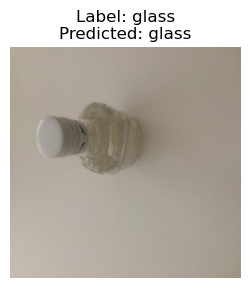

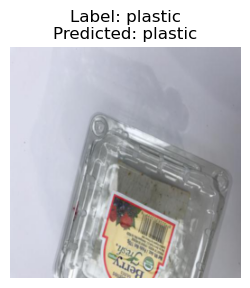

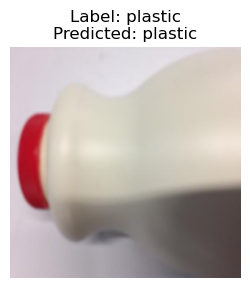

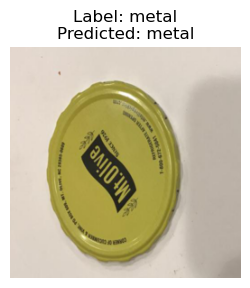

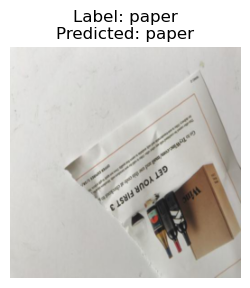

In [49]:
def predict_image(img, model):
    model.eval()
    xb = img.unsqueeze(0) # adiciona dimensão de batch

    with torch.no_grad():
        yb = model(xb)
    prob, preds = torch.max(yb, dim=1)

    return dataset.classes[preds[0].item()]

def show_predictions(n=6):
    for i in range(n):
        img, label = test_data[i]
        pred = predict_image(img, model)
        plt.figure(figsize=(3, 3))
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Label: {dataset.classes[label]}\nPredicted: {pred}")
        plt.axis("off")
        plt.show()

show_predictions(n=5)